## Gathering real time Forex data from TrueFx ##

It works throught the free website TrueFx that provides real time access to the major currency pairs.

It makes a request every n seconds and stores the *ask price* data in a pandas DataFrame.

It stores in the same dataframe multiple currency pairs, since the website provide real time information for multiple currency pairs at once.

It doesnt care for bid, open, high, close prices. It only stores **ask** prices.

It stores every time resquest ask price in columns, one colum per curreny pair:

['request time', 'currency-pair ask price 0', 'currency-pair ask price 1'... etc ] 

e. g.

                                time 	EUR/USD 	AUD/USD 	GBP/USD 	USD/JPY 	USD/CAD
    
    "0 	2016-05-27 19:33:29.035429 	1.11125 	0.71885 	1.46109 	110.0035 	1.30293"

    "1 	2016-05-27 19:33:59.392546 	1.11125 	0.71885 	1.46109 	110.0035 	1.30293"







### "Principal Quotes" True Fx ###
Anonymous can download

1. EUR/USD
2. USD/JPY
3. GBP/USD
4. EUR/GBP
5. USD/CHF
6. EUR/JPY
7. EUR/CHF
8. USD/CAD
9. AUD/USD
10. GBP/JPY

### Important to know Forex Market Times ### 

Is it close? Is it on its more stable hours?

http://forex.timezoneconverter.com/?timezone=America/Sao_Paulo;

In [1]:
from matplotlib import pyplot
%pylab inline
import urllib.request
import re
import pandas
import datetime
import time
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


The **ask/offer** is the buying price and **bid** is the selling price

Since what matters most in my case ups and dows is the ask price I'll gather just this for evaluation of trends.

I'll **store only ASK prices**, for my quotes.

**Python 3.0 work**

Connect

In [2]:
quotes=['EUR/USD', 'AUD/USD', 'GBP/USD', 'EUR/GBP', 'USD/CHF', 'USD/CAD']
login ='u=aflopes7&p=gig1684&q=ozrates&c='+','.join(quotes)+'&f=csv&s=y'
pgtrfx = 'http://webrates.truefx.com/rates/connect.html?'   

response = urllib.request.urlopen(pgtrfx+login)
session = response.read().decode().strip()
print(session)

aflopes7:gig1684:ozrates:1464630433987


Request

In [3]:
#quotes=['EUR/USD','AUD/USD']
#quotes = ['time' ] + quotes
#print(quotes)

In [4]:
def record_quotes(quotes=['EUR/USD','AUD/USD'], sample_interval=15, nsamples=30, verbose=False):
    #columns = ['time', 'AUD/USD' etc..]
    # one colum per currency forex pair ONLY ASK PRICE stored
    data_askquotes = pandas.DataFrame(columns=['time']+quotes) 
    
    # requesting page TrueFx
    #quotes = 'AUD/USD,USD/JPY' # requested quotes separated by comma
    #', '.join(quotes)
    login ='u=aflopes7&p=gig1684&q=ozrates&c='+','.join(quotes)+'&f=csv&s=y'
    pgtrfx = 'http://webrates.truefx.com/rates/connect.html?'    
    #print(login)
    #print(pgtrfx)

    # first connection create session
    response = urllib.request.urlopen(pgtrfx+login)
    session = response.read().decode().strip()
    
    # to read the txt response (only float values)
    rx = re.compile("[-+]?\d*\.\d+|\d+", re.VERBOSE) 
    
    i = 0
    while i < nsamples:
        try:
            # after connection
            # request the cote, it is page response in bytes that needs to be converted to 'str'
            pgreturn = urllib.request.urlopen(pgtrfx+'id='+session).read().decode()
            pgreturn = pgreturn.split('\n') # each line is a cote (currency pair)
            quotes_ask = [None] * len(quotes) # empty list of ask price for each cote (currency pair)     
            for p in range(len(quotes)): # for each cote read/store its respective line                
                # ignore first decimal number is timestamp
                bid, bidpt, ask, askpt, high, low, openn = list(map(float, rx.findall(pgreturn[p])))[1:]
                #bid, ask = bid+bidpt*0.00001, ask+askpt*0.00001 
                # price is divided in two parts points + ticks
                quotes_ask[p] = ask+askpt*0.00001 
            dit = dict(zip(['time'] + quotes, [ datetime.datetime.now() ] + quotes_ask))
            data_askquotes = data_askquotes.append(dit, ignore_index=True)   
            if verbose:
                print(dfdata.tail(1)) # print the last one
        except: # reconnect dont increment
            response = urllib.request.urlopen(pgtrfx+login)
            session = response.read().decode().strip()
        else: # increment and wait time delay
            time.sleep(sample_interval)
            i = i+1     
    
    return data_askquotes

In [5]:
# every 30 s, 120 samples per hour x N hours
dt=30; smph=120; nh=6;  
dfdata = record_quotes(quotes=quotes, sample_interval=dt, nsamples=smph*nh) 
dfdata = dfdata.set_index(pandas.DatetimeIndex(dfdata['time']))
del dfdata['time'] #not need anymore
dfdata.to_pickle('quotes_14hs_30_may_16_6hours.pandas')

In [14]:
#plot(dfdata['EUR/USD'].values)

,time,EUR/USD,AUD/USD,GBP/USD,EUR/GBP,USD/CHF,USD/CAD
0,2016-05-30 14:47:51.944203,1.11383,0.71863,1.46362,0.76111,0.99234,1.30592


In [15]:
df = pandas.read_pickle('quotes_14hs_30_may_16_6hours.pandas')
quotes=['EUR/USD', 'AUD/USD', 'GBP/USD', 'EUR/GBP', 'USD/CHF', 'USD/CAD']

In [23]:
#df = df.set_index(pandas.DatetimeIndex(df['time']))
#df.to_pickle('quotes_14hs_30_may_16_6hours.pandas')

In [20]:
# remove this collumn that is flat?
#del df['USD/JPY']

In [21]:
from matplotlib import pyplot
%matplotlib inline
#pyplot.figure()

def plot_quotes(quotes, dataframe):    
    f, axr = pyplot.subplots(len(quotes), sharex=True, figsize=(15,10))
    for i, ax in enumerate(axr):
        df.iloc[:,i+1].plot(ax=axr[i])
        axr[i].set_ylabel(quotes[i])

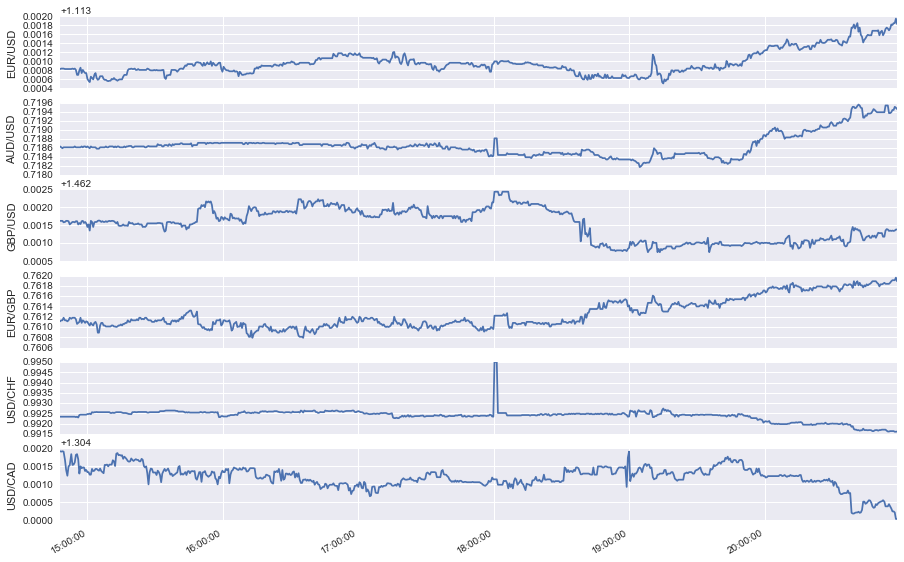

In [22]:
plot_quotes(quotes, df)